In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper

import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import torchmetrics
import torch.jit as jit
import timm
from functools import partial
from typing import List
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size=4
image_count=50
img_size=256
tf = ToTensor()


In [2]:
train_image_No_closure_path='../../data/image_data1/1/No_closure/1*'
train_image_Oropharynx_path='../../data/image_data1/1/Oropharynx/1*'
train_image_Tonguebase_path='../../data/image_data1/1/Tonguebase/1*'
train_image_Epiglottis_path='../../data/image_data1/1/Epiglottis/1*'
test_image_No_closure_path='../../data/image_data1_test/1/No_closure/1*'
test_image_Oropharynx_path='../../data/image_data1_test/1/Oropharynx/1*'
test_image_Tonguebase_path='../../data/image_data1_test/1/Tonguebase/1*'
test_image_Epiglottis_path='../../data/image_data1_test/1/Epiglottis/1*'
# class CustomDataset(Dataset):
#     def __init__(self, image_list, label_list):
#         self.img_path = image_list

#         self.label = label_list


#     def __len__(self):
#         return len(self.label)

#     def __getitem__(self, idx):
#         image_tensor = torch.empty((image_count,3, img_size, img_size))
        
#         image_file_list = glob(self.img_path[idx]+'/*.jpg')
#         if len(image_file_list)>image_count:
#             image_index = torch.randint(low=0, high=len(
#                 image_file_list)-image_count, size=(1,))
#             count = 0
#             for index in range(image_index[0],image_index[0]+image_count):
#                 image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
#                 image_tensor[count] = image
#                 count += 1
#         else:
#             count = 0
#             for index in range(len(image_file_list)):
#                 image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
#                 image_tensor[count] = image
#                 count += 1
#             for i in range(image_count-count):
#                 image = 1-tf(Image.open(image_file_list[i]).resize((img_size,img_size)))
#                 image_tensor[count] = image
#                 count += 1
#         label_tensor =  self.label[idx]
#         return image_tensor, label_tensor
    
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list

        self.label = label_list


    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        image_tensor = self.img_path[idx]
    
        label_tensor =  self.label[idx]
        return image_tensor, label_tensor

train_image_list = []
train_label_list = []
image_No_closure_list = glob(train_image_No_closure_path)
image_No_closure_label = torch.zeros(len(image_No_closure_list), 1)
image_Oropharynx_list = glob(train_image_Oropharynx_path)
image_Oropharynx_label = torch.ones(len(image_Oropharynx_list), 1)
image_Tonguebase_list = glob(train_image_Tonguebase_path)
image_Tonguebase_label = torch.ones(len(image_Tonguebase_list), 1)*2
image_Epiglottis_list = glob(train_image_Epiglottis_path)
image_Epiglottis_label = torch.ones(len(image_Epiglottis_list), 1)*3

train_image_list.extend(image_No_closure_list)
train_image_list.extend(image_Oropharynx_list)
train_image_list.extend(image_Tonguebase_list)
train_image_list.extend(image_Epiglottis_list)
train_label_list.extend(image_No_closure_label)
train_label_list.extend(image_Oropharynx_label)
train_label_list.extend(image_Tonguebase_label)
train_label_list.extend(image_Epiglottis_label)

train_image_tensor = torch.empty((len(train_image_list),image_count,3, img_size, img_size))
for i in tqdm(range(len(train_image_list))):   
    image_file_list = glob(train_image_list[i]+'/*.jpg')
    if len(image_file_list)>image_count:
        image_index = torch.randint(low=0, high=len(
            image_file_list)-image_count, size=(1,))
        count = 0
        for index in range(image_count):
            image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
            train_image_tensor[i,count] = image
            count += 1
    else:
        count = 0
        for index in range(0,len(image_file_list)):
            image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
            train_image_tensor[i,count] = image
            count += 1
        for j in range(image_count-count):
            image = 1-tf(Image.open(image_file_list[j]).resize((img_size,img_size)))
            train_image_tensor[i,count] = image
            count += 1

test_image_list = []
test_label_list = []
image_No_closure_list = glob(test_image_No_closure_path)
image_No_closure_label = torch.zeros(len(image_No_closure_list), 1)
image_Oropharynx_list = glob(test_image_Oropharynx_path)
image_Oropharynx_label = torch.ones(len(image_Oropharynx_list), 1)
image_Tonguebase_list = glob(test_image_Tonguebase_path)
image_Tonguebase_label = torch.ones(len(image_Tonguebase_list), 1)*2
image_Epiglottis_list = glob(test_image_Epiglottis_path)
image_Epiglottis_label = torch.ones(len(image_Epiglottis_list), 1)*3

test_image_list.extend(image_No_closure_list)
test_image_list.extend(image_Oropharynx_list)
test_image_list.extend(image_Tonguebase_list)
test_image_list.extend(image_Epiglottis_list)
test_label_list.extend(image_No_closure_label)
test_label_list.extend(image_Oropharynx_label)
test_label_list.extend(image_Tonguebase_label)
test_label_list.extend(image_Epiglottis_label)

test_image_tensor = torch.empty((len(test_image_list),image_count,3, img_size, img_size))
for i in tqdm(range(len(test_image_list))):   
    image_file_list = glob(test_image_list[i]+'/*.jpg')
    if len(image_file_list)>image_count:
        image_index = torch.randint(low=0, high=len(
            image_file_list)-image_count, size=(1,))
        count = 0
        for index in range(image_count):
            image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
            test_image_tensor[i,count] = image
            count += 1
    else:
        count = 0
        for index in range(len(image_file_list)):
            image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
            test_image_tensor[i,count] = image
            count += 1
        for j in range(image_count-count):
            image = 1-tf(Image.open(image_file_list[j]).resize((img_size,img_size)))
            test_image_tensor[i,count] = image
            count += 1
            
train_dataset = CustomDataset(torch.transpose(train_image_tensor,1,2), F.one_hot(torch.tensor(train_label_list).to(torch.int64)))

test_dataset = CustomDataset(torch.transpose(test_image_tensor,1,2), F.one_hot(torch.tensor(test_label_list).to(torch.int64)))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

In [ ]:
def get_inplanes():
    return [64, 128, 256, 512]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=3,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=4):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model


model = generate_model(50)
model = model.to(device)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)
summary(model,(batch_size,3,image_count,img_size,img_size))

In [4]:
train_label_list.extend(test_label_list)

train_dataset = CustomDataset(torch.cat((torch.transpose(train_image_tensor,1,2),torch.transpose(test_image_tensor,1,2)),dim=0), F.one_hot(torch.tensor(train_label_list).to(torch.int64)))

test_dataset = CustomDataset(torch.transpose(test_image_tensor,1,2), F.one_hot(torch.tensor(test_label_list).to(torch.int64)))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

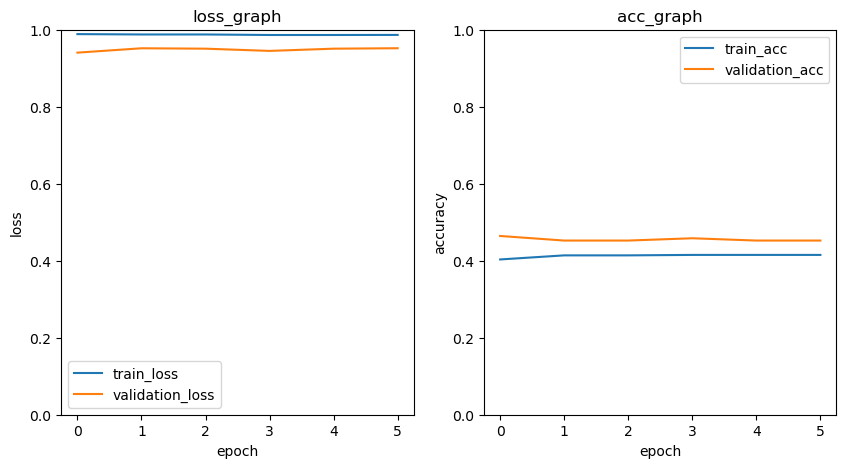

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

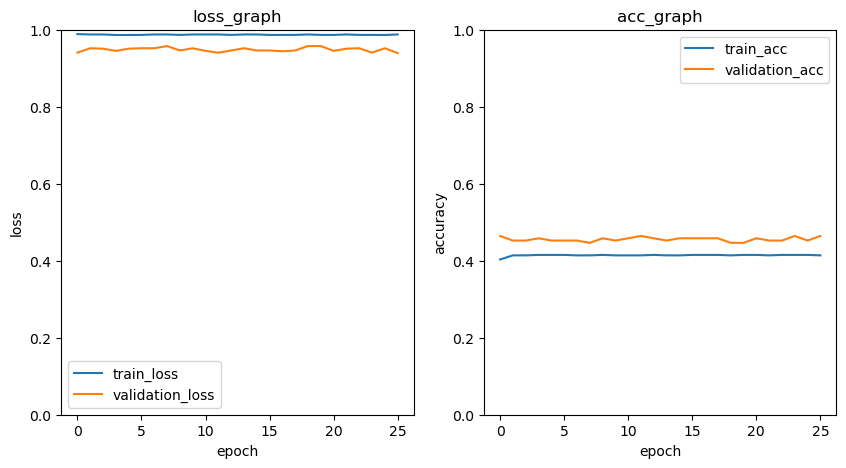

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

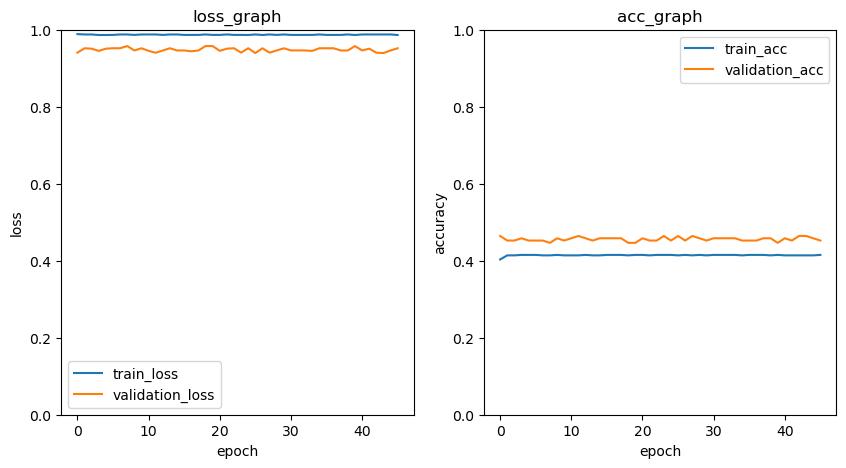

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

: 

In [5]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
sig=nn.Sigmoid()
val_acc_list=[]
MIN_acc=0
numSample_list = [len(image_No_closure_list),len(image_Oropharynx_list),len(image_Tonguebase_list),len(image_Epiglottis_list)]
weights = torch.Tensor([1 - (x / sum(numSample_list)) for x in numSample_list]).to(device)

for epoch in range(50):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    model.train()
    for x, y in train:
        
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = F.cross_entropy(predict.softmax(dim=1), y,weight=weights) # cost 구함
        acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} loss : {running_loss/count:.4f} accuracy: {acc_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count).cpu().detach().numpy())
#validation
    val=tqdm(validation_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            predict = model(x).to(device)
            cost = F.cross_entropy(predict.softmax(dim=1), y,weight=weights) # cost 구함
            acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
            val_running_loss+=cost.item()
            acc_loss+=acc
            val.set_description(f"Validation epoch: {epoch+1}/{1000} Step: {count+1} loss : {val_running_loss/count:.4f}  accuracy: {acc_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count).cpu().detach().numpy())
    if epoch%20==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
        
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/3D_CNN_1_loss50_callback.pt')
        MIN_loss=(val_running_loss/count)
        
    if MIN_acc<(acc_loss/count):
        torch.save(model.state_dict(), '../../model/3D_CNN_1_acc50_callback.pt')
        MIN_acc=(acc_loss/count)
        
torch.save(model.state_dict(), '../../model/3D_CNN_1_50.pt')